# Carregando os dados

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import seaborn as sns

In [34]:
%%time
transactions_2009_2010 = pd.read_excel('../online_retail_II.xlsx',sheet_name="Year 2009-2010", engine='openpyxl')
transactions_2010_2011= pd.read_excel('../online_retail_II.xlsx',sheet_name="Year 2010-2011", engine='openpyxl')

CPU times: total: 2min 46s
Wall time: 3min


In [35]:
# Concatenar os DataFrames (empilhar as linhas)
df = pd.concat([transactions_2009_2010, transactions_2010_2011], ignore_index=True)

# Exibir as primeiras linhas do DataFrame combinado
print(df.shape)

(1067371, 8)


In [36]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1067371 non-null  object        
 1   StockCode    1067371 non-null  object        
 2   Description  1062989 non-null  object        
 3   Quantity     1067371 non-null  int64         
 4   InvoiceDate  1067371 non-null  datetime64[ns]
 5   Price        1067371 non-null  float64       
 6   Customer ID  824364 non-null   float64       
 7   Country      1067371 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 65.1+ MB


([<matplotlib.axis.YTick at 0x18fe39f32b0>,
 [Text(0, 0, 'Invoice'),
  Text(0, 1, 'StockCode'),
  Text(0, 2, 'Description'),
  Text(0, 3, 'Quantity'),
  Text(0, 4, 'InvoiceDate'),
  Text(0, 5, 'Price'),
  Text(0, 6, 'Customer ID'),
  Text(0, 7, 'Country')])

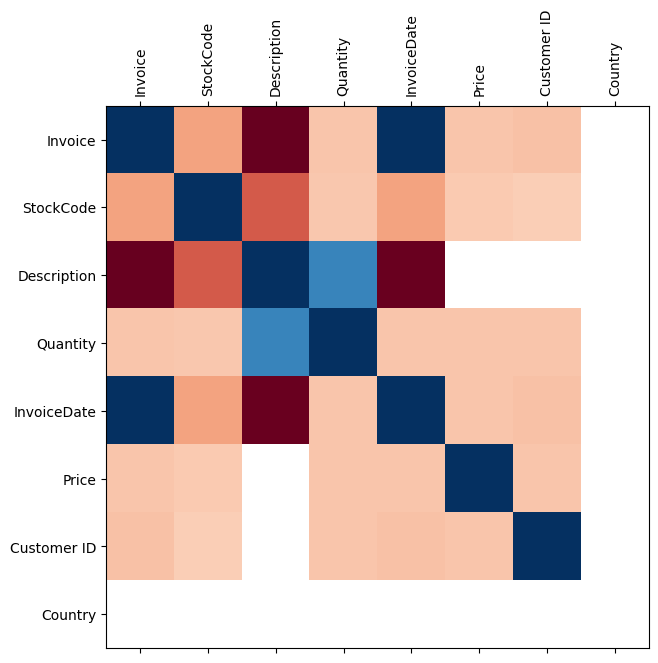

In [38]:
# Análise de correlação de dados
# Convert all columns to numeric, replacing errors with NaN
df_numeric = df.apply(pd.to_numeric, errors='coerce')
correlation = df_numeric.corr()
fig = plt.figure(figsize=(7,7))
plt.matshow(correlation, cmap='RdBu', fignum=fig.number)
plt.xticks(range(len(correlation.columns)), correlation.columns, rotation='vertical')
plt.yticks(range(len(correlation.columns)), correlation.columns)

# Limpeza de Dados

In [39]:
# Verificando valores ausentes
df.isna().sum()

# Obtêm os transações canceladas
df_cancelled = df[df['Invoice'].astype(str).str.contains('C', na=False)]

# Remove as transações canceladas
df = df[~df['Invoice'].astype(str).str.contains('C', na=False)]

# Verificando valores númericos
df['Invoice'] = pd.to_numeric(df['Invoice'], errors='coerce')

df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

df['Description'] = df['Description'].astype(str)

# Análise de Dados Básicos

    Invoice StockCode                          Description  Quantity  \
0  489434.0     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434.0    79323P                   PINK CHERRY LIGHTS        12   
2  489434.0    79323W                  WHITE CHERRY LIGHTS        12   
3  489434.0     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434.0     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

          InvoiceDate  Price  Customer ID         Country   ano  mes  dia  \
0 2009-12-01 07:45:00   6.95      13085.0  United Kingdom  2009   12    1   
1 2009-12-01 07:45:00   6.75      13085.0  United Kingdom  2009   12    1   
2 2009-12-01 07:45:00   6.75      13085.0  United Kingdom  2009   12    1   
3 2009-12-01 07:45:00   2.10      13085.0  United Kingdom  2009   12    1   
4 2009-12-01 07:45:00   1.25      13085.0  United Kingdom  2009   12    1   

   hora  semana_mes  
0     7          49  
1     7          49  
2     7          49  
3     7         

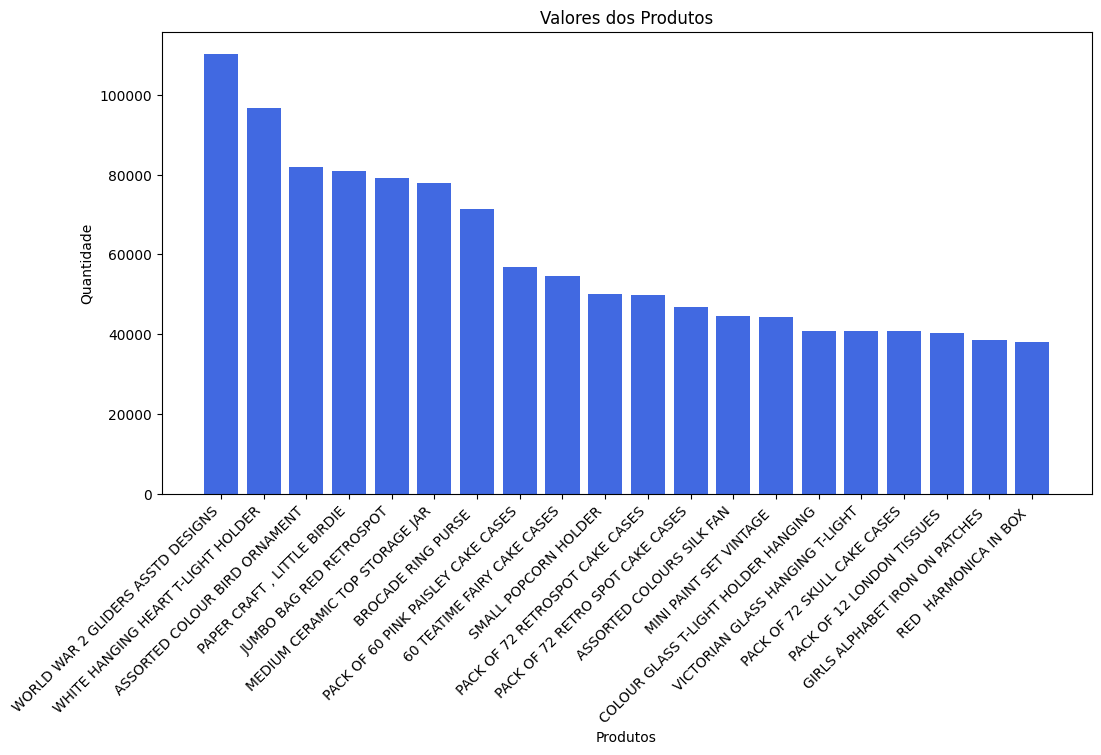

In [40]:
# Adiciona a coluna ano
df['ano'] = df['InvoiceDate'].dt.year

df['mes'] = df['InvoiceDate'].dt.month

df['dia'] = df['InvoiceDate'].dt.day

df['hora'] = df['InvoiceDate'].dt.hour

df['semana_mes'] = df['InvoiceDate'].dt.isocalendar().week

# print(df[df['Description'].empty ==].head(5))
print(df.head(5))

# Agrupoar por produto e somar as quantidades vendidas
top_products = df.groupby('Description')['Quantity'].sum().reset_index()

# Ordenar do mais vendido para o menos vendido
top_products = top_products.sort_values(by='Quantity', ascending=False)
# print(top_products.head(20))

# Criando o gráfico de barras
plt.figure(figsize=(12, 6))
plt.bar(top_products['Description'].head(20), top_products['Quantity'].head(20), color='royalblue')
plt.xticks(rotation=45, ha='right')
# Adicionando rótulos e título
plt.xlabel("Produtos")
plt.ylabel("Quantidade")
plt.title("Valores dos Produtos")
# Exibindo o gráfico
plt.show()

                              Description  Quantity
5373    WORLD WAR 2 GLIDERS ASSTD DESIGNS    110249
5252   WHITE HANGING HEART T-LIGHT HOLDER     96688
328         ASSORTED COLOUR BIRD ORNAMENT     81817
3261          PAPER CRAFT , LITTLE BIRDIE     80995
2503              JUMBO BAG RED RETROSPOT     79285
2813       MEDIUM CERAMIC TOP STORAGE JAR     78033
799                   BROCADE RING PURSE      71440
3197   PACK OF 60 PINK PAISLEY CAKE CASES     56794
168           60 TEATIME FAIRY CAKE CASES     54716
4694                 SMALL POPCORN HOLDER     49984
3200      PACK OF 72 RETROSPOT CAKE CASES     49805
3199     PACK OF 72 RETRO SPOT CAKE CASES     46755
340             ASSORTED COLOURS SILK FAN     44485
2880              MINI PAINT SET VINTAGE      44405
1167  COLOUR GLASS T-LIGHT HOLDER HANGING     40839
5047      VICTORIAN GLASS HANGING T-LIGHT     40748
3201          PACK OF 72 SKULL CAKE CASES     40733
3162           PACK OF 12 LONDON TISSUES      40367
2027      GI

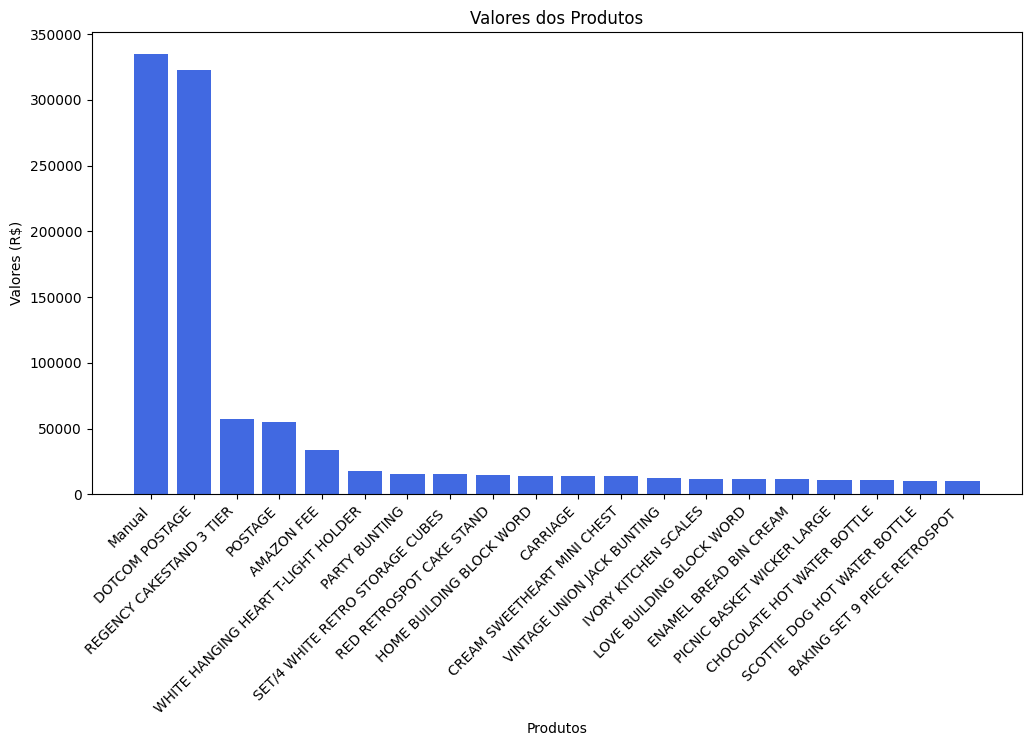

In [41]:
# Agrupoar por produto e somar as quantidades vendidas
top_products_revenue = df.groupby('Description')['Price'].sum().reset_index()

# Ordenar do mais vendido para o menos vendido
top_products_revenue = top_products_revenue.sort_values(by='Price', ascending=False)
print(top_products.head(20))

# Criando o gráfico de barras
plt.figure(figsize=(12, 6))
plt.bar(top_products_revenue['Description'].head(20), top_products_revenue['Price'].head(20), color='royalblue')
plt.xticks(rotation=45, ha='right')
# Adicionando rótulos e título
plt.xlabel("Produtos")
plt.ylabel("Valores (R$)")
plt.title("Valores dos Produtos")
# Exibindo o gráfico
plt.show()

In [42]:
# Mostrar o total de vendas
df['Invoice'].unique().shape[0]

45331

In [ ]:
# Agrupa por Invoice e soma as quantidades de cada pedido
quantidade_por_pedido = df.groupby('Invoice')['Quantity'].sum()

# Calcula a média de produtos por pedido
media_produtos_por_pedido = quantidade_por_pedido.mean()

print(f"Média de produtos por pedido: {media_produtos_por_pedido:.2f}")

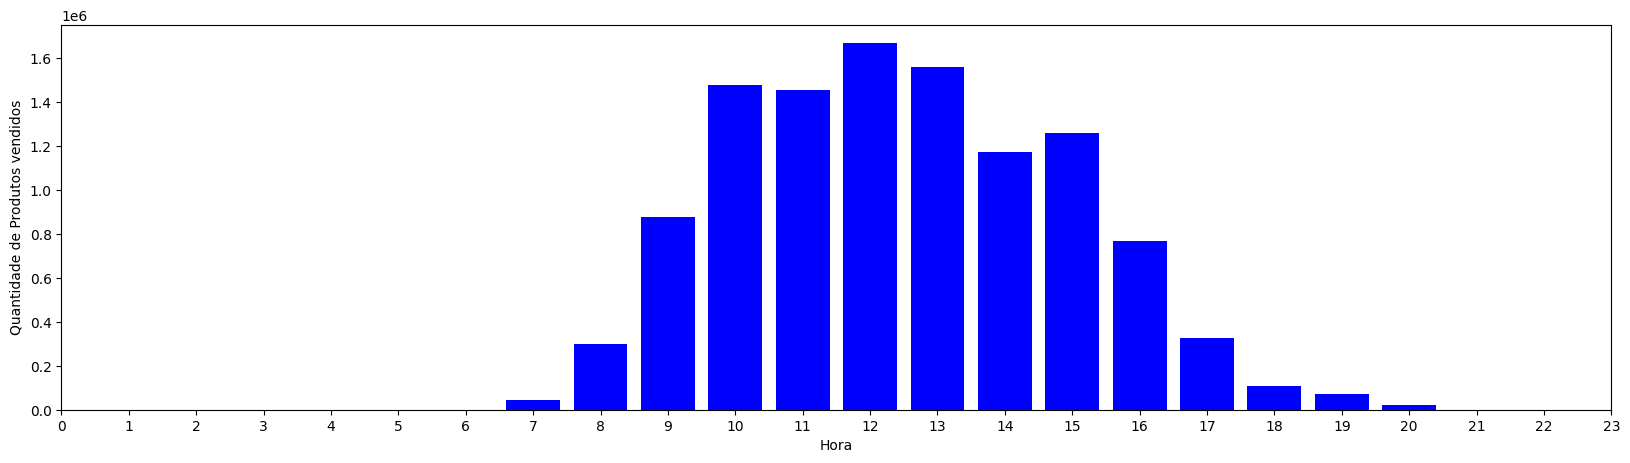

In [43]:
top_hours = df.groupby('hora')['Quantity'].sum().reset_index()

# print(top_hours.head(24))

# Qual hora do dia tem o maior número de pedidos?
plt.figure(figsize=(20,5))
plt.bar(top_hours['hora'], top_hours['Quantity'], color='blue')
plt.xticks(np.arange(0, 24, 1))
plt.xlabel('Hora')
plt.ylabel('Quantidade de Produtos vendidos')
plt.show()


# Total de vendas por tempo(diário, semanal, mensal)

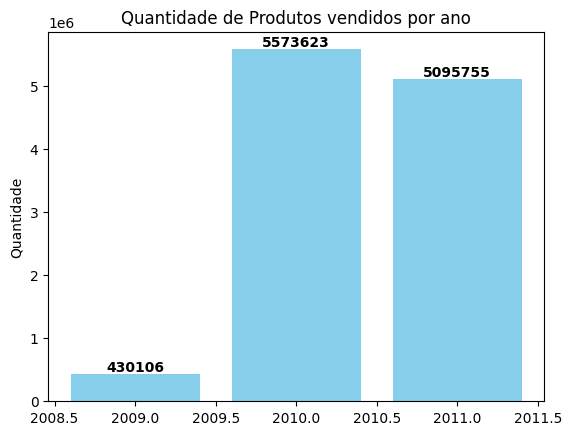

In [44]:
# Total de vendas por ano
df_by_year = df.groupby('ano', as_index=False)['Quantity'].sum()

# Criar o gráfico de barras
fig, ax = plt.subplots()
barras = ax.bar(df_by_year['ano'], df_by_year['Quantity'], color='skyblue')

# Adicionar os valores nas barras
for barra in barras:
    altura = barra.get_height()
    ax.text(barra.get_x() + barra.get_width()/2, altura, 
            f'{altura}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Configurar rótulos e título
ax.set_ylabel('Quantidade')
ax.set_title('Quantidade de Produtos vendidos por ano')

# Mostrar o gráfico
plt.show()

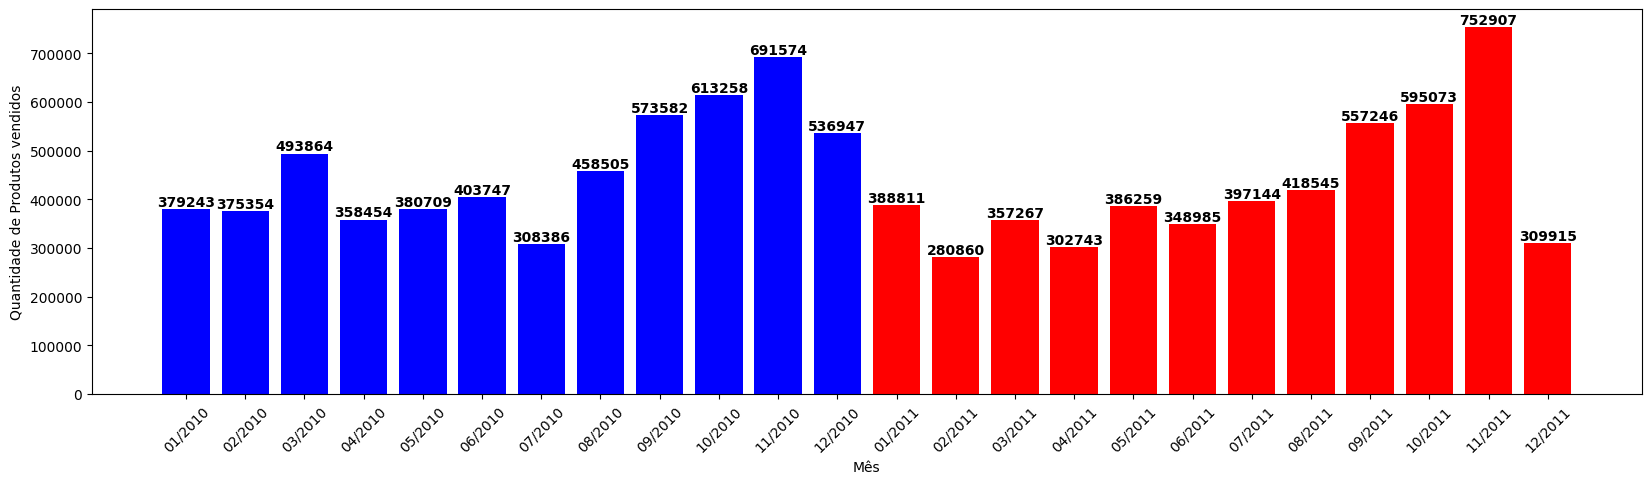

In [45]:
# Total de vendas por mês
df_by_month = df.groupby(['ano','mes'], as_index=False)['Quantity'].sum().reset_index()

df_by_month['date'] = df_by_month['mes'].astype(str).str.zfill(2) + "/" + df_by_month['ano'].astype(str)

df_by_month_2010 = df_by_month.loc[df_by_month['ano'] == 2010]

plt.figure(figsize=(20,5))
barras_2010 = plt.bar(df_by_month['date'].loc[df_by_month['ano'] == 2010], df_by_month['Quantity'].loc[df_by_month['ano'] == 2010], color='blue')
barras_2011 = plt.bar(df_by_month['date'].loc[df_by_month['ano'] == 2011], df_by_month['Quantity'].loc[df_by_month['ano'] == 2011], color='red')
for barra in barras_2010:
    altura = barra.get_height()
    plt.text(barra.get_x() + barra.get_width()/2, altura, 
            f'{altura}', ha='center', va='bottom', fontsize=10, fontweight='bold')
for barra in barras_2011:
    altura = barra.get_height()
    plt.text(barra.get_x() + barra.get_width()/2, altura, 
            f'{altura}', ha='center', va='bottom', fontsize=10, fontweight='bold')
# plt.xticks(np.arange(0, 13, 1))
plt.xlabel('Mês')
plt.xticks(rotation=45)
plt.ylabel('Quantidade de Produtos vendidos')
plt.show()

In [46]:
# Total de vendas semanal
df_by_week = df.groupby(['ano', 'mes', 'semana_mes'], as_index=False)['Quantity'].sum()

print(df_by_week)

      ano  mes  semana_mes  Quantity
0    2009   12          49    139921
1    2009   12          50    116800
2    2009   12          51    134263
3    2009   12          52     39122
4    2010    1           1     93386
..    ...  ...         ...       ...
116  2011   11          46    181307
117  2011   11          47    166050
118  2011   11          48     86842
119  2011   12          48     66739
120  2011   12          49    243176

[121 rows x 4 columns]


In [47]:
# Transações vendidas por dia
df_by_day = df.groupby(['ano', 'mes', 'dia'], as_index=False)['Quantity'].sum()

print(df_by_day)

      ano  mes  dia  Quantity
0    2009   12    1     24652
1    2009   12    2     30208
2    2009   12    3     47298
3    2009   12    4     21107
4    2009   12    5      5033
..    ...  ...  ...       ...
599  2011   12    5     44244
600  2011   12    6     30133
601  2011   12    7     39720
602  2011   12    8     35099
603  2011   12    9     93980

[604 rows x 4 columns]


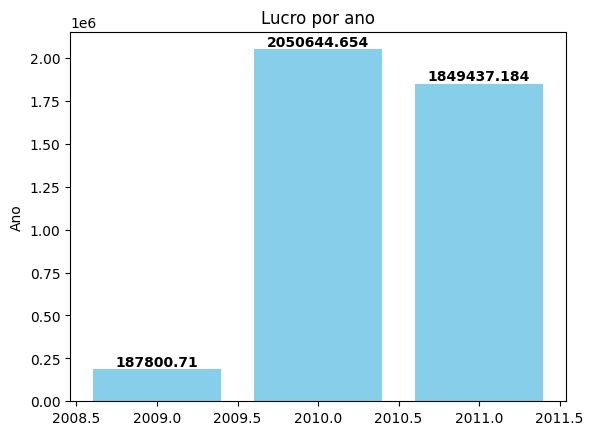

In [48]:
# Total de vendas por ano
prices_by_year = df.groupby('ano', as_index=False)['Price'].sum()

fig, ax = plt.subplots()
barras = ax.bar(prices_by_year['ano'], prices_by_year['Price'], color='skyblue')

# Adicionar os valores nas barras
for barra in barras:
    altura = barra.get_height()
    ax.text(barra.get_x() + barra.get_width()/2, altura, 
            f'{altura}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Configurar rótulos e título
ax.set_ylabel('Ano')
ax.set_title('Lucro por ano')

# Mostrar o gráfico
plt.show()

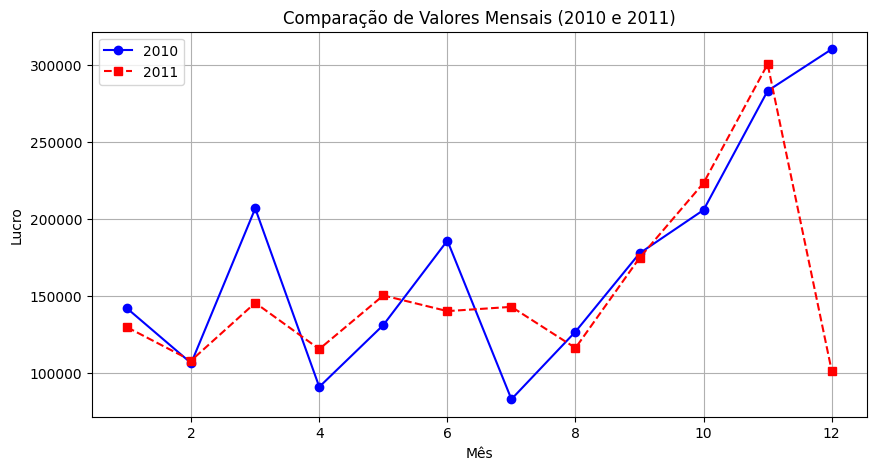

In [49]:
# Total de vendas por mês
# prices_by_month = df_filtered.groupby('mes', as_index=False)['Price'].sum()
prices_by_month = df.groupby(['ano', 'mes'], as_index=False).agg({'Price': 'sum'})

prices_by_month_filtered = prices_by_month.loc[prices_by_month['ano'] == 2011]

prices_by_month_2011 = prices_by_month[prices_by_month['ano'] == 2011]
prices_by_month_2010 = prices_by_month[prices_by_month['ano'] == 2010]

plt.figure(figsize=(10, 5))
plt.plot(prices_by_month_2010['mes'], prices_by_month_2010['Price'],  marker='o', linestyle='-', label='2010', color='blue')
plt.plot(prices_by_month_2011['mes'], prices_by_month_2011['Price'], marker='s', linestyle='--', label='2011', color='red')

plt.xlabel('Mês')
plt.ylabel('Lucro')
plt.title('Comparação de Valores Mensais (2010 e 2011)')
plt.legend()
plt.grid(True)


# Mostrar o gráfico
plt.show()

# Análise de Recorrência de Clientes

In [50]:
#  [Text(0, 0, 'Invoice'),
#   Text(0, 1, 'StockCode'),
#   Text(0, 2, 'Description'),
#   Text(0, 3, 'Quantity'),
#   Text(0, 4, 'InvoiceDate'),
#   Text(0, 5, 'Price'),
#   Text(0, 6, 'Customer ID'),
#   Text(0, 7, 'Country')

df_sorted = df.sort_values(by=['Customer ID', 'InvoiceDate'])

df_sorted['dias_entre_compras'] = df_sorted.groupby('Customer ID')['InvoiceDate'].diff().dt.days

media_dias_por_cliente = df_sorted.groupby('Customer ID')['dias_entre_compras'].mean().reset_index()
media_dias_por_cliente.rename(columns={'dias_entre_compras': 'media_dias_recompra'}, inplace=True)
print(media_dias_por_cliente)


      Customer ID  media_dias_recompra
0         12346.0            11.969697
1         12347.0             1.583333
2         12348.0             7.240000
3         12349.0             3.270115
4         12350.0             0.000000
...           ...                  ...
5876      18283.0             0.653807
5877      18284.0             0.000000
5878      18285.0             0.000000
5879      18286.0             3.742424
5880      18287.0             3.409091

[5881 rows x 2 columns]


In [51]:
compras_por_cliente = df.groupby('Customer ID')['Invoice'].count().reset_index()
compras_por_cliente = compras_por_cliente.rename(columns={"Invoice": "qtd_compras"})
compras_por_cliente['tipo_cliente'] = compras_por_cliente['qtd_compras'].apply(
    lambda x: "recorrente" if x > 1 else "novo"
)
print(compras_por_cliente.sort_values(by='qtd_compras', ascending=False).head(5))

      Customer ID  qtd_compras tipo_cliente
5436      17841.0        12890   recorrente
2541      14911.0        11247   recorrente
400       12748.0         7230   recorrente
2239      14606.0         6566   recorrente
1732      14096.0         5111   recorrente


In [52]:
# Juntar os dois dataframes
df = df.merge(compras_por_cliente, on='Customer ID', how='left')
df = df.merge(media_dias_por_cliente, on='Customer ID', how='left')

In [53]:
clientes_total = df["Customer ID"].nunique()
clientes_recorrentes = df[df["tipo_cliente"] == "recorrente"]["Customer ID"].nunique()

taxa_retencao = (clientes_recorrentes / clientes_total) * 100
print(f"Taxa de Retenção: {taxa_retencao:.0f}%")

Taxa de Retenção: 98%


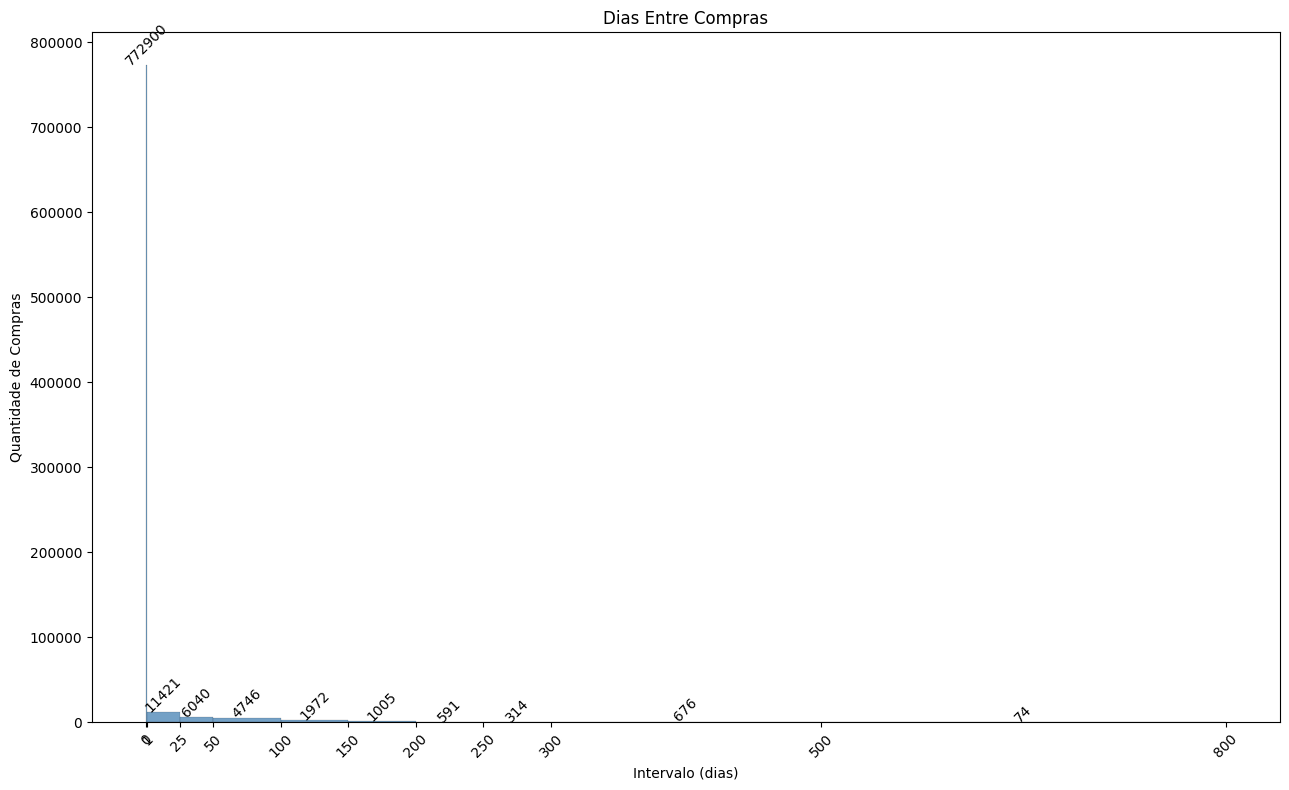

In [54]:
# Filtrar apenas clientes com mais de uma compra
dias_validos = df_sorted["dias_entre_compras"].dropna()

# print(dias_validos.sort_values(ascending=False))
plt.figure(figsize=(13, 8))

# Criar o histograma e capturar os dados do gráfico
ax = sns.histplot(dias_validos, bins=[0, 1, 25, 50, 100, 150, 200, 250, 300, 500, 800], kde=False, color='steelblue', )
# ax = sns.histplot(dias_validos, bins=[0, 1, 2, 3, 4, 5, 6], kde=False, color='steelblue')

# Adiciona os valores manualmente nas barras
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.text(p.get_x() + p.get_width()/2, height + 0.5, int(height), ha="center", rotation=45)

plt.title("Dias Entre Compras")
plt.xlabel("Intervalo (dias)")
plt.ylabel("Quantidade de Compras")
plt.xticks(ticks=[0, 1, 25, 50, 100, 150, 200, 250, 300, 500, 800], rotation=45)
plt.tight_layout()
plt.show()

Top 10 clientes mais recorrentes:
Customer ID
14911.0    398
12748.0    337
17841.0    211
15311.0    208
13089.0    203
14606.0    192
14156.0    156
17850.0    155
14646.0    152
18102.0    145
Name: Invoice, dtype: int64


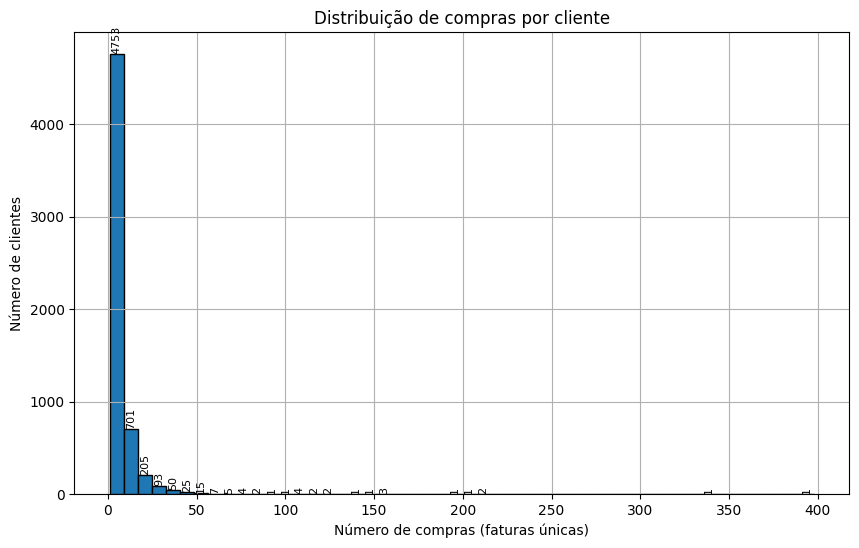

In [ ]:
# Remove linhas sem Customer ID
df_clientes = df.dropna(subset=['Customer ID'])

# Conta quantas faturas (compras) cada cliente realizou
compras_por_cliente = df_clientes.groupby('Customer ID')['Invoice'].nunique()

# Exibe os top 10 clientes mais recorrentes
top_clientes = compras_por_cliente.sort_values(ascending=False).head(10)
print("Top 10 clientes mais recorrentes:")
print(top_clientes)

# Plota a distribuição
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(compras_por_cliente, bins=50, edgecolor='black')
# Adiciona rótulos em cima de cada barra
for count, bin_edge, patch in zip(n, bins, patches):
    if count > 0:
        plt.text(
            x=patch.get_x() + patch.get_width() / 2,  # centraliza no topo da barra
            y=count,
            s=f'{int(count)}',
            ha='center',
            va='bottom',
            fontsize=8,
            rotation=90,
        )
plt.title("Distribuição de compras por cliente")
plt.xlabel("Número de compras (faturas únicas)")
plt.ylabel("Número de clientes")
plt.grid(True)
plt.show()

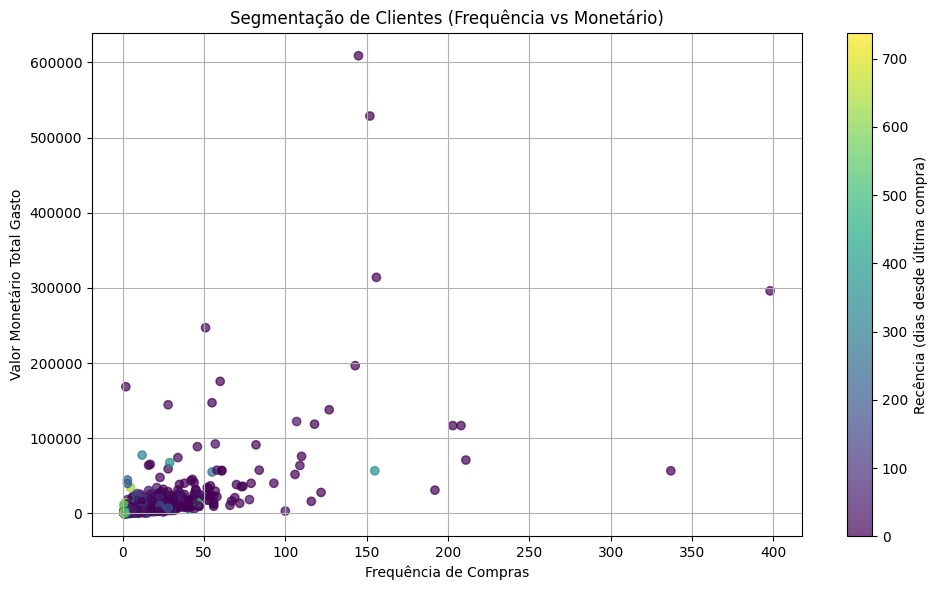

In [ ]:
# Agrupa os dados por cliente
rfm = df_clientes.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (df['InvoiceDate'].max() - x.max()).days,  # Recência
    'Invoice': 'nunique',                                               # Frequência
    'Price': lambda x: (x * df_clientes.loc[x.index, 'Quantity']).sum() # Monetário
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

# Gráfico de dispersão: Frequência x Monetário
plt.figure(figsize=(10, 6))
scatter = plt.scatter(rfm['Frequency'], rfm['Monetary'], 
                      c=rfm['Recency'], cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Recência (dias desde última compra)')
plt.title('Segmentação de Clientes (Frequência vs Monetário)')
plt.xlabel('Frequência de Compras')
plt.ylabel('Valor Monetário Total Gasto')
plt.grid(True)
plt.tight_layout()
plt.show()


# Em desenvolviment

In [55]:
# Tabela de recompra com checkmark
matriz_recompra = df.groupby(["Customer ID", "mes"]).size().unstack().fillna(0)
matriz_recompra = matriz_recompra.applymap(lambda x: "✓" if x > 0 else "")
print(matriz_recompra)

mes         1  2  3  4  5  6  7  8  9  10 11 12
Customer ID                                    
12346.0      ✓     ✓        ✓                 ✓
12347.0      ✓        ✓     ✓     ✓     ✓     ✓
12348.0      ✓        ✓              ✓        ✓
12349.0               ✓  ✓              ✓  ✓   
12350.0         ✓                              
...         .. .. .. .. .. .. .. .. .. .. .. ..
18283.0      ✓  ✓  ✓  ✓  ✓  ✓  ✓  ✓  ✓  ✓  ✓  ✓
18284.0                                 ✓      
18285.0         ✓                              
18286.0                           ✓           ✓
18287.0                  ✓           ✓  ✓  ✓   

[5881 rows x 12 columns]


# TODO Futuras implementações

In [56]:
# Coisas que podemos fazer
# Comparar datas da primeira compra até a compra mais recente
# df['rental_days'] = df[['rental_date', 'return_date']].apply(lambda x: (x[1] - x[0]).days, axis=1)
# Usar bokeh

In [57]:
# from bokeh.plotting import figure, output_file, show
# from bokeh.io import output_notebook